## Data Preprocessing

In [26]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [12]:
# Hàm đọc ảnh và trích xuất HOG
def load_images_from_folder(folder, label, size=(64,64)):
    data, labels = [], []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            # resize cho đồng nhất
            img = cv2.resize(img, size)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # trích xuất HOG feature
            features, _ = hog(gray, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(2,2), block_norm='L2-Hys', visualize=True)
            data.append(features)
            labels.append(label)
    return data, labels

# Load dữ liệu train
X, y = [], []

# 1 = có kính, 0 = không kính
data1, label1 = load_images_from_folder("dataset/train/glasses", 1)
data2, label2 = load_images_from_folder("dataset/train/noglasses", 0)

X.extend(data1 + data2)
y.extend(label1 + label2)

X = np.array(X)
y = np.array(y)

print("Kích thước dữ liệu train:", X.shape, y.shape)


Kích thước dữ liệu train: (104, 1764) (104,)


In [14]:
# Tách dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None



--- Báo cáo phân loại (Classification Report) ---
              precision    recall  f1-score   support

  Không kính       0.91      1.00      0.95        10
     Có kính       1.00      0.91      0.95        11

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21


--- Ma trận nhầm lẫn (Confusion Matrix) ---
[[10  0]
 [ 1 10]]


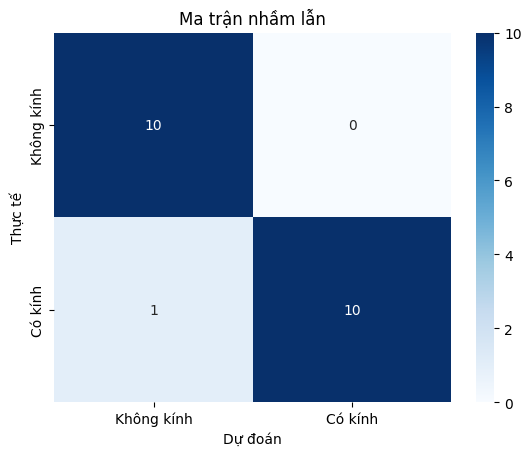

Độ chính xác của mô hình KNN: 95.24%


In [ ]:
# Đánh giá mô hình
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Báo cáo phân loại (Classification Report) ---")
print(classification_report(y_test, y_pred, target_names=['Không kính', 'Có kính']))

print("\n--- Ma trận nhầm lẫn (Confusion Matrix) ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

labels = ['Không kính', 'Có kính']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()
print(f"Độ chính xác của mô hình KNN: {accuracy * 100:.2f}%")

In [24]:
# Sử dụng PCA để giảm chiều dữ liệu xuống 2D.
# Quan trọng: Huấn luyện PCA trên TOÀN BỘ dữ liệu (X) sau đó transform X_train và X_test
pca = PCA(n_components=2)
X_reduced_all = pca.fit_transform(X) # Giảm chiều toàn bộ dữ liệu để vẽ ranh giới

# Bây giờ, giảm chiều X_train_raw và y_train_raw cho KNN
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

# Huấn luyện lại KNN trên dữ liệu đã giảm chiều để vẽ ranh giới chính xác hơn trên không gian 2D
knn_reduced = KNeighborsClassifier(n_neighbors=5)
knn_reduced.fit(X_train_reduced, y_train)

# Đánh giá lại mô hình trên dữ liệu giảm chiều
y_pred_reduced = knn_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f"Độ chính xác của mô hình KNN trên dữ liệu PCA: {accuracy_reduced * 100:.2f}%")


Độ chính xác của mô hình KNN trên dữ liệu PCA: 95.24%


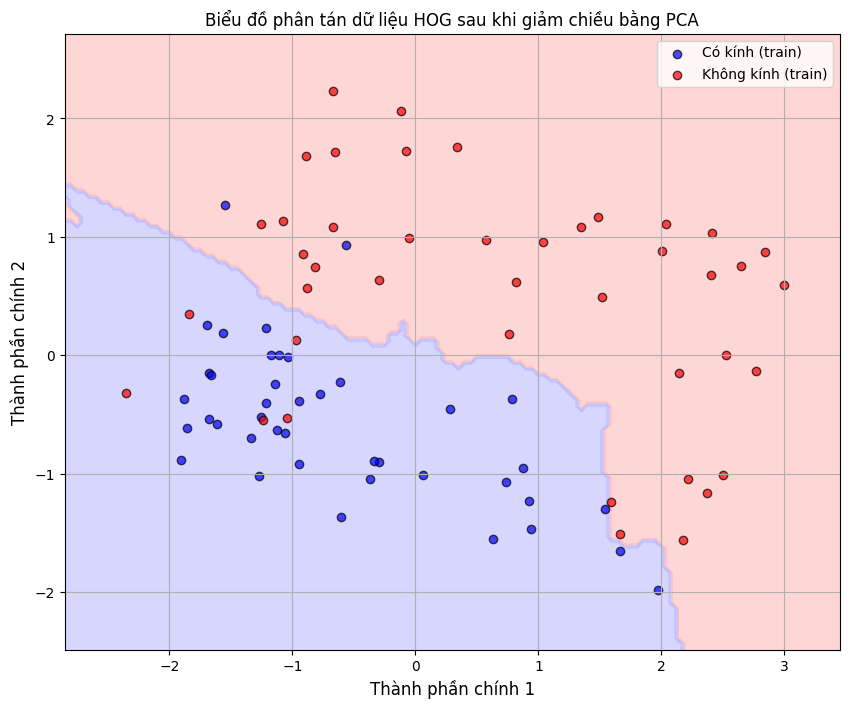

In [25]:
plt.figure(figsize=(10, 8))

# Định nghĩa các màu cho vùng nền
cmap_light = ListedColormap(['#FFBBBB', '#BBBBFF']) # Màu nhạt cho vùng lớp 0 và lớp 1
cmap_bold = ListedColormap(['#FF0000', '#0000FF']) # Màu đậm cho các điểm dữ liệu

# Tạo lưới điểm để tính toán ranh giới quyết định
x_min, x_max = X_reduced_all[:, 0].min() - 0.5, X_reduced_all[:, 0].max() + 0.5
y_min, y_max = X_reduced_all[:, 1].min() - 0.5, X_reduced_all[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), # Bước nhỏ để ranh giới mượt mà
                     np.arange(y_min, y_max, 0.05))

# Dự đoán lớp cho mỗi điểm trong lưới
Z = knn_reduced.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Vẽ vùng ranh giới quyết định
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

# Vẽ các điểm dữ liệu huấn luyện
plt.scatter(X_train_reduced[y_train == 1, 0], X_train_reduced[y_train == 1, 1],
            c='blue', label='Có kính (train)', alpha=0.7, edgecolors='k')
plt.scatter(X_train_reduced[y_train == 0, 0], X_train_reduced[y_train == 0, 1],
            c='red', label='Không kính (train)', alpha=0.7, edgecolors='k')

plt.title(f'Biểu đồ phân tán dữ liệu HOG sau khi giảm chiều bằng PCA')
plt.xlabel('Thành phần chính 1', fontsize=12)
plt.ylabel('Thành phần chính 2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()